# Cube and Data Warehouse

In [1]:
import atoti as tt

Welcome to Atoti 0.8.10!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


In [2]:
session = tt.Session(
    user_content_storage=".content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"]
)

In [3]:
db_name = "olympic_olap"
db_user = "postgres"
db_password = "postgres"  
db_host = "pgdb"  # Update if your DB is hosted elsewhere
db_port = "5432"

jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

In [4]:
combined_fact_table = session.read_sql(
    """
    SELECT
        id,
        game_slug,
        participant_id,
        athlete_id,
        event_id,
        country_code,
        CAST(year AS CHAR(4)) AS year,  -- Casting year to string directly in SQL
        total_bronze_medals,
        total_silver_medals,
        total_gold_medals,
        total_medals,
        poverty_count,
        gdp_per_capita,
        annual_gdp_growth,
        servers_count,
        daly_depression,
        daly_schizophrenia,
        daly_bipolar_disorder,
        daly_eating_disorder,
        daly_anxiety,
        life_expectancy,
        infant_mortality_rate,
        current_health_expenditure,
        government_health_expenditure,
        private_health_expenditure,
        external_health_expenditure
    FROM combinedfacttable
    """,
    keys=["id"],
    table_name="CombinedFactTable",
    url=jdbc_url,
)

In [5]:
dimlocation_table = session.read_sql(
    "SELECT * FROM DimLocation",
    keys=["country_code"],
    table_name="DimLocation",
    url=jdbc_url)

In [6]:
dimevent_table = session.read_sql(
    "SELECT * FROM DimEvent",
    keys=["event_id"],
    table_name="DimEvent",
    url=jdbc_url,
)

In [7]:
dimparticipant_table = session.read_sql(
    "SELECT * FROM DimParticipant",
    keys=["participant_id"],
    table_name="DimParticipant",
    url=jdbc_url,
)

In [8]:
dimathlete_table = session.read_sql(
    "SELECT * FROM DimAthlete",
    keys=["athlete_id"],
    table_name="DimAthlete",
    url=jdbc_url,
)

In [9]:
dimyear_table = session.read_sql(
    "SELECT CAST(year AS CHAR(4)) AS year FROM DimYear",
    keys=["year"],
    table_name="DimYear",
    url=jdbc_url,
)

In [10]:
dimgame_table = session.read_sql(
    "SELECT * FROM DimGame",
    keys=["game_slug"],
    table_name="DimGame",
    url=jdbc_url,
)

In [11]:
combined_fact_table.join(dimlocation_table, combined_fact_table["country_code"] == dimlocation_table["country_code"])

combined_fact_table.join(dimevent_table, combined_fact_table["event_id"] == dimevent_table["event_id"])

combined_fact_table.join(dimparticipant_table, combined_fact_table["participant_id"] == dimparticipant_table["participant_id"])

combined_fact_table.join(dimathlete_table, combined_fact_table["athlete_id"] == dimathlete_table["athlete_id"])

combined_fact_table.join(dimyear_table, combined_fact_table["year"] == dimyear_table["year"])

combined_fact_table.join(dimgame_table, combined_fact_table["game_slug"] == dimgame_table["game_slug"])

In [12]:
combined_fact_table['year']

In [13]:
session.tables.schema

```mermaid
erDiagram
  "DimAthlete" {
    _ int PK "athlete_id"
    _ String "athlete_name"
    _ String "athlete_url"
  }
  "DimLocation" {
    _ String PK "country_code"
    _ String "country_name"
    _ String "continent"
  }
  "DimEvent" {
    _ int PK "event_id"
    _ String "event_title"
    _ String "event_discipline"
    _ String "event_gender"
  }
  "CombinedFactTable" {
    _ int PK "id"
    _ String "game_slug"
    nullable int "participant_id"
    nullable int "athlete_id"
    nullable int "event_id"
    _ String "country_code"
    _ String "year"
    nullable int "total_bronze_medals"
    nullable int "total_silver_medals"
    nullable int "total_gold_medals"
    nullable int "total_medals"
    nullable double "poverty_count"
    nullable double "gdp_per_capita"
    nullable double "annual_gdp_growth"
    nullable int "servers_count"
    nullable double "daly_depression"
    nullable double "daly_schizophrenia"
    nullable double "daly_bipolar_disorder"
    nullable double "daly_eating_disorder"
    nullable double "daly_anxiety"
    nullable double "life_expectancy"
    nullable double "infant_mortality_rate"
    nullable double "current_health_expenditure"
    nullable double "government_health_expenditure"
    nullable double "private_health_expenditure"
    nullable double "external_health_expenditure"
  }
  "DimParticipant" {
    _ int PK "participant_id"
    _ String "participant_title"
    _ String "participant_type"
  }
  "DimYear" {
    _ String PK "year"
  }
  "DimGame" {
    _ String PK "game_slug"
    _ String "game_name"
    _ String "game_season"
    nullable int "game_year"
    _ String "country_code"
  }
  "CombinedFactTable" }o--o| "DimLocation" : "`country_code` == `country_code`"
  "CombinedFactTable" }o--o| "DimGame" : "`game_slug` == `game_slug`"
  "CombinedFactTable" }o--o| "DimParticipant" : "`participant_id` == `participant_id`"
  "CombinedFactTable" }o--o| "DimYear" : "`year` == `year`"
  "CombinedFactTable" }o--o| "DimAthlete" : "`athlete_id` == `athlete_id`"
  "CombinedFactTable" }o--o| "DimEvent" : "`event_id` == `event_id`"
```


In [14]:
cube = session.create_cube(combined_fact_table)

In [15]:
cube

In [16]:
hierarchies, levels, measures = cube.hierarchies, cube.levels, cube.measures

In [17]:
hierarchies

{('CombinedFactTable', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c3e10>, ('CombinedFactTable', 'id'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c3450>, ('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c1dd0>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c0b90>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c3910>, ('CombinedFactTable', 'game_slug'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c15d0>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c2310>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c1590>, ('CombinedFactTable', 'year'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c1610>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c1b90>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c2a90>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c3410>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c34d0>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c2290>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c2890>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c0f50>}

In [18]:
hierarchies["Year"] = [dimyear_table["year"]]

In [19]:
hierarchies

{('CombinedFactTable', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04d2d10>, ('CombinedFactTable', 'id'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ccbd0>, ('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cdf90>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cd250>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cc650>, ('CombinedFactTable', 'game_slug'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cf050>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ce410>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cead0>, ('CombinedFactTable', 'year'): <atoti.hierarchy.Hierarchy object at 0x7fffb050cad0>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb050c890>, ('DimYear', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7fffb050c650>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb050c3d0>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb050c510>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb050e010>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb050ce90>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb050ca10>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb050d890>}

In [20]:
# List all hierarchies in the cube to find the correct name
for hierarchy in hierarchies:
    print(hierarchy)


('CombinedFactTable', 'country_code')
('CombinedFactTable', 'id')
('DimParticipant', 'participant_title')
('DimAthlete', 'athlete_name')
('DimGame', 'game_season')
('CombinedFactTable', 'game_slug')
('DimParticipant', 'participant_type')
('DimEvent', 'event_discipline')
('CombinedFactTable', 'year')
('DimEvent', 'event_gender')
('DimYear', 'Year')
('DimLocation', 'country_name')
('DimAthlete', 'athlete_url')
('DimEvent', 'event_title')
('DimGame', 'game_name')
('DimLocation', 'continent')
('DimGame', 'country_code')


In [21]:
# Remove a specific unwanted hierarchy
del hierarchies[('CombinedFactTable', 'country_code')]
del hierarchies[('CombinedFactTable', 'id')]
del hierarchies[('CombinedFactTable', 'game_slug')]
del hierarchies[('CombinedFactTable', 'year')]

In [22]:
hierarchies

{('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cdc10>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0530510>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb0530bd0>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533790>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533890>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533990>, ('DimYear', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533a90>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533b90>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533c90>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533d90>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533e90>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb0533f90>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb03400d0>}

In [23]:
levels

In [24]:
hierarchies["DimAthlete"] = [levels["athlete_name"]]

In [25]:
hierarchies["DimEvent"] = [levels["event_title"], levels[("DimEvent", "event_discipline", "event_discipline")],
                           levels[("DimEvent", "event_gender", "event_gender")]]

In [26]:
hierarchies["DimGame"] = [levels["game_name"], levels[("DimGame", "game_season", "game_season")]]

In [27]:
hierarchies["DimLocation"]  = [levels["country_name"], levels[("DimLocation", "continent", "continent")]]

In [28]:
hierarchies["DimParticipant"] = [levels["participant_title"], levels[("DimParticipant", "participant_type", "participant_type")]]

In [29]:
hierarchies

{('DimLocation', 'DimLocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb0605d10>, ('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb047f710>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb047e750>, ('DimGame', 'DimGame'): <atoti.hierarchy.Hierarchy object at 0x7fffb047ec90>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb047e410>, ('DimEvent', 'DimEvent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ff450>, ('DimAthlete', 'DimAthlete'): <atoti.hierarchy.Hierarchy object at 0x7fffb04fd190>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ffa90>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb04fca50>, ('DimParticipant', 'DimParticipant'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ffc90>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ffe50>, ('DimYear', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7fffb04fc450>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ff890>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb04fe1d0>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04fcf10>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04fc850>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ff290>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ff3d0>}

In [30]:
hierarchies["DimYear"] = [levels["year"]]


In [31]:
hierarchies

{('DimLocation', 'DimLocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ca850>, ('DimParticipant', 'participant_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04ca750>, ('DimAthlete', 'athlete_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8190>, ('DimGame', 'DimGame'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8210>, ('DimGame', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8810>, ('DimEvent', 'DimEvent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8d90>, ('DimAthlete', 'DimAthlete'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c85d0>, ('DimParticipant', 'participant_type'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cb650>, ('DimEvent', 'event_discipline'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8550>, ('DimParticipant', 'DimParticipant'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8650>, ('DimEvent', 'event_gender'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c96d0>, ('DimYear', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c9f10>, ('DimYear', 'DimYear'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c9250>, ('DimLocation', 'country_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c8e90>, ('DimAthlete', 'athlete_url'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cbe90>, ('DimEvent', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c9710>, ('DimGame', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fffb04c93d0>, ('DimLocation', 'continent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cb810>, ('DimGame', 'country_code'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cbbd0>}

In [32]:
for hierarchy in hierarchies:
    print(hierarchy)

('DimLocation', 'DimLocation')
('DimParticipant', 'participant_title')
('DimAthlete', 'athlete_name')
('DimGame', 'DimGame')
('DimGame', 'game_season')
('DimEvent', 'DimEvent')
('DimAthlete', 'DimAthlete')
('DimParticipant', 'participant_type')
('DimEvent', 'event_discipline')
('DimParticipant', 'DimParticipant')
('DimEvent', 'event_gender')
('DimYear', 'Year')
('DimYear', 'DimYear')
('DimLocation', 'country_name')
('DimAthlete', 'athlete_url')
('DimEvent', 'event_title')
('DimGame', 'game_name')
('DimLocation', 'continent')
('DimGame', 'country_code')


In [33]:
del hierarchies[("DimAthlete", "athlete_name")]

In [34]:
del hierarchies[('DimAthlete', 'athlete_url')]

In [35]:
del hierarchies[('DimEvent', 'event_gender')]
del hierarchies[('DimEvent', 'event_title')]
del hierarchies[('DimEvent', 'event_discipline')]

In [36]:
del hierarchies[('DimGame', 'game_season')]
del hierarchies[('DimGame', 'country_code')]
del hierarchies[('DimGame', 'game_name')]

In [37]:
del hierarchies[('DimLocation', 'country_name')]
del hierarchies[('DimLocation', 'continent')]


In [38]:
del hierarchies[('DimParticipant', 'participant_title')]
del hierarchies[('DimParticipant', 'participant_type')]

In [39]:
del hierarchies[('DimYear', 'Year')]

In [40]:
hierarchies

{('DimParticipant', 'DimParticipant'): <atoti.hierarchy.Hierarchy object at 0x7fffb0354290>, ('DimLocation', 'DimLocation'): <atoti.hierarchy.Hierarchy object at 0x7fffb0482f90>, ('DimYear', 'DimYear'): <atoti.hierarchy.Hierarchy object at 0x7fffb0481890>, ('DimGame', 'DimGame'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cd810>, ('DimEvent', 'DimEvent'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cdfd0>, ('DimAthlete', 'DimAthlete'): <atoti.hierarchy.Hierarchy object at 0x7fffb04cd990>}

In [41]:
measures


{'contributors.COUNT': <atoti.measure.Measure object at 0x7fffb04fe2d0>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x7fffb04ffd10>, 'total_silver_medals.MEAN': <atoti.measure.Measure object at 0x7fffb04ff1d0>, 'total_silver_medals.SUM': <atoti.measure.Measure object at 0x7fffb047e2d0>, 'participant_id.MEAN': <atoti.measure.Measure object at 0x7fffb047f110>, 'participant_id.SUM': <atoti.measure.Measure object at 0x7fffb047c510>, 'annual_gdp_growth.MEAN': <atoti.measure.Measure object at 0x7fffb047ea50>, 'annual_gdp_growth.SUM': <atoti.measure.Measure object at 0x7fffb047ec90>, 'total_gold_medals.MEAN': <atoti.measure.Measure object at 0x7fffb047f410>, 'total_gold_medals.SUM': <atoti.measure.Measure object at 0x7fffb047d890>, 'daly_schizophrenia.MEAN': <atoti.measure.Measure object at 0x7fffb1741ed0>, 'daly_schizophrenia.SUM': <atoti.measure.Measure object at 0x7fffb1741750>, 'total_bronze_medals.MEAN': <atoti.measure.Measure object at 0x7fffb1742390>, 'total_bronze_medals.SUM': <atoti.measure.Measure object at 0x7fffb0388c50>, 'athlete_id.MEAN': <atoti.measure.Measure object at 0x7fffb0388b90>, 'athlete_id.SUM': <atoti.measure.Measure object at 0x7fffb0388c90>, 'daly_bipolar_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb0388cd0>, 'daly_bipolar_disorder.SUM': <atoti.measure.Measure object at 0x7fffb0388d10>, 'external_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0388d50>, 'external_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0388d90>, 'infant_mortality_rate.MEAN': <atoti.measure.Measure object at 0x7fffb0388dd0>, 'infant_mortality_rate.SUM': <atoti.measure.Measure object at 0x7fffb0388e10>, 'government_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0388e50>, 'government_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0388e90>, 'servers_count.MEAN': <atoti.measure.Measure object at 0x7fffb0388ed0>, 'servers_count.SUM': <atoti.measure.Measure object at 0x7fffb0388f10>, 'event_id.MEAN': <atoti.measure.Measure object at 0x7fffb0388f50>, 'event_id.SUM': <atoti.measure.Measure object at 0x7fffb0388f90>, 'current_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0388fd0>, 'current_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0389010>, 'poverty_count.MEAN': <atoti.measure.Measure object at 0x7fffb0389050>, 'poverty_count.SUM': <atoti.measure.Measure object at 0x7fffb0389090>, 'total_medals.MEAN': <atoti.measure.Measure object at 0x7fffb03890d0>, 'total_medals.SUM': <atoti.measure.Measure object at 0x7fffb0389110>, 'daly_anxiety.MEAN': <atoti.measure.Measure object at 0x7fffb0389150>, 'daly_anxiety.SUM': <atoti.measure.Measure object at 0x7fffb0389190>, 'gdp_per_capita.MEAN': <atoti.measure.Measure object at 0x7fffb03891d0>, 'gdp_per_capita.SUM': <atoti.measure.Measure object at 0x7fffb0389210>, 'life_expectancy.MEAN': <atoti.measure.Measure object at 0x7fffb0389250>, 'life_expectancy.SUM': <atoti.measure.Measure object at 0x7fffb0389290>, 'daly_eating_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb03892d0>, 'daly_eating_disorder.SUM': <atoti.measure.Measure object at 0x7fffb0389310>, 'private_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb0389350>, 'private_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb0389390>, 'daly_depression.MEAN': <atoti.measure.Measure object at 0x7fffb03893d0>, 'daly_depression.SUM': <atoti.measure.Measure object at 0x7fffb0389410>}

In [42]:
del measures["athlete_id.MEAN"]


In [43]:
del measures["contributors.COUNT"]

In [44]:
del measures["athlete_id.SUM"]

In [45]:
del measures["event_id.MEAN"]

In [46]:
del measures["event_id.SUM"]
del measures["participant_id.MEAN"]
del measures["participant_id.SUM"]

In [47]:
measures

{'update.TIMESTAMP': <atoti.measure.Measure object at 0x7fffb03a9650>, 'total_silver_medals.MEAN': <atoti.measure.Measure object at 0x7fffb03a96d0>, 'total_silver_medals.SUM': <atoti.measure.Measure object at 0x7fffb03a9710>, 'annual_gdp_growth.MEAN': <atoti.measure.Measure object at 0x7fffb03a9750>, 'annual_gdp_growth.SUM': <atoti.measure.Measure object at 0x7fffb03a9790>, 'total_gold_medals.MEAN': <atoti.measure.Measure object at 0x7fffb03a97d0>, 'total_gold_medals.SUM': <atoti.measure.Measure object at 0x7fffb03a9810>, 'daly_schizophrenia.MEAN': <atoti.measure.Measure object at 0x7fffb03a9850>, 'daly_schizophrenia.SUM': <atoti.measure.Measure object at 0x7fffb03a9890>, 'total_bronze_medals.MEAN': <atoti.measure.Measure object at 0x7fffb03a98d0>, 'total_bronze_medals.SUM': <atoti.measure.Measure object at 0x7fffb03a9910>, 'daly_bipolar_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb03a9950>, 'daly_bipolar_disorder.SUM': <atoti.measure.Measure object at 0x7fffb03a9990>, 'external_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb03a99d0>, 'external_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb03a9a10>, 'infant_mortality_rate.MEAN': <atoti.measure.Measure object at 0x7fffb03a9a50>, 'infant_mortality_rate.SUM': <atoti.measure.Measure object at 0x7fffb03a9a90>, 'government_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb03a9ad0>, 'government_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb03a9b10>, 'servers_count.MEAN': <atoti.measure.Measure object at 0x7fffb03a9b50>, 'servers_count.SUM': <atoti.measure.Measure object at 0x7fffb03a9b90>, 'current_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb03a9bd0>, 'current_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb03a9c10>, 'poverty_count.MEAN': <atoti.measure.Measure object at 0x7fffb03a9c50>, 'poverty_count.SUM': <atoti.measure.Measure object at 0x7fffb03a9c90>, 'total_medals.MEAN': <atoti.measure.Measure object at 0x7fffb03a9cd0>, 'total_medals.SUM': <atoti.measure.Measure object at 0x7fffb03a9d10>, 'daly_anxiety.MEAN': <atoti.measure.Measure object at 0x7fffb03a9d50>, 'daly_anxiety.SUM': <atoti.measure.Measure object at 0x7fffb03a9d90>, 'gdp_per_capita.MEAN': <atoti.measure.Measure object at 0x7fffb03a9dd0>, 'gdp_per_capita.SUM': <atoti.measure.Measure object at 0x7fffb03a9e10>, 'life_expectancy.MEAN': <atoti.measure.Measure object at 0x7fffb03a9e50>, 'life_expectancy.SUM': <atoti.measure.Measure object at 0x7fffb03a9e90>, 'daly_eating_disorder.MEAN': <atoti.measure.Measure object at 0x7fffb03a9ed0>, 'daly_eating_disorder.SUM': <atoti.measure.Measure object at 0x7fffb03a9f10>, 'private_health_expenditure.MEAN': <atoti.measure.Measure object at 0x7fffb03a9f50>, 'private_health_expenditure.SUM': <atoti.measure.Measure object at 0x7fffb03a9f90>, 'daly_depression.MEAN': <atoti.measure.Measure object at 0x7fffb03a9fd0>, 'daly_depression.SUM': <atoti.measure.Measure object at 0x7fffb03aa010>}

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
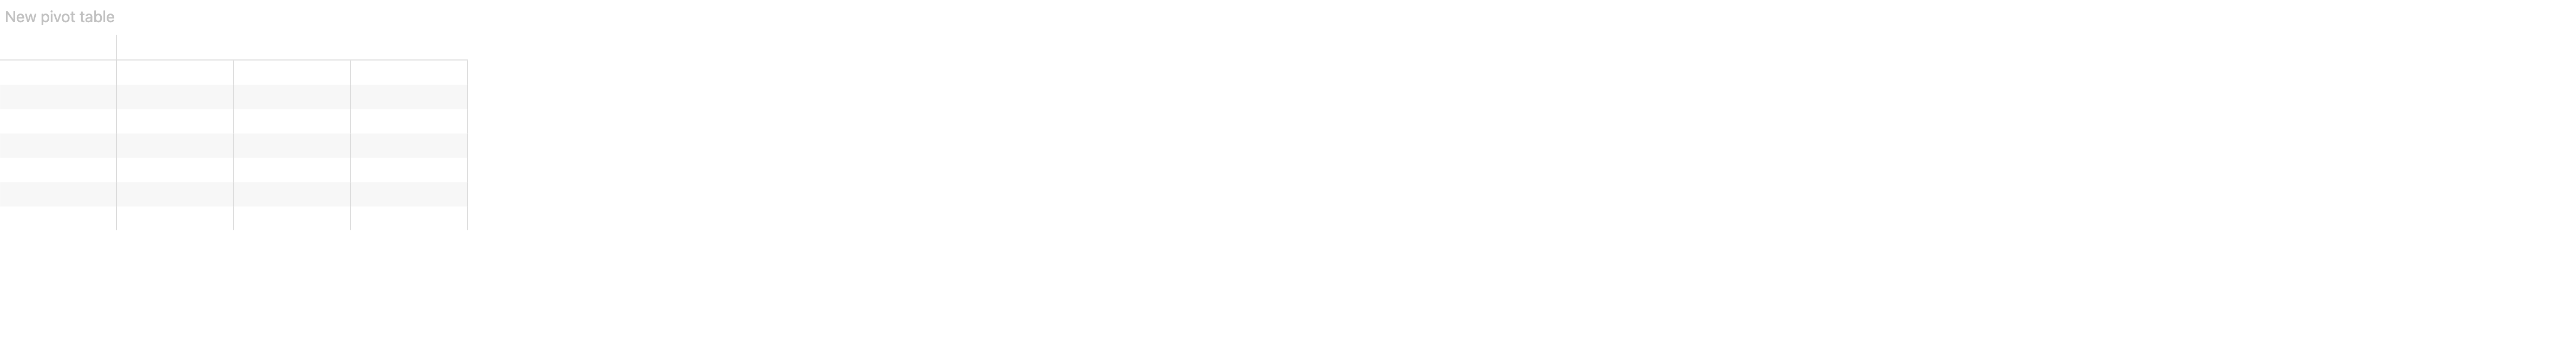

In [48]:
session.widget

In [49]:
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

In [50]:
# m["Price.VALUE"] = tt.agg.single_value(table["Price"])

measures["daly_anxiety.VALUE"] = tt.agg.single_value(combined_fact_table["daly_anxiety"])

In [51]:
measures["daly_bipolar_disorder.VALUE"] = tt.agg.single_value(combined_fact_table["daly_bipolar_disorder"])

In [52]:
measures["daly_depression.VALUE"] = tt.agg.single_value(combined_fact_table["daly_depression"])

In [53]:
measures["daly_eating_disorder.VALUE"] = tt.agg.single_value(combined_fact_table["daly_eating_disorder"])

In [54]:
measures["daly_schizophrenia.VALUE"] = tt.agg.single_value(combined_fact_table["daly_schizophrenia"])

In [55]:
measures["life_expectancy.VALUE"] = tt.agg.single_value(combined_fact_table["life_expectancy"])

In [56]:
measures["current_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["current_health_expenditure"])

In [57]:
measures["external_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["external_health_expenditure"])

In [58]:
measures["government_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["government_health_expenditure"])

In [59]:
measures["infant_mortality_rate.VALUE"] = tt.agg.single_value(combined_fact_table["infant_mortality_rate"])

In [60]:
measures["private_health_expenditure.VALUE"] = tt.agg.single_value(combined_fact_table["private_health_expenditure"])

In [61]:
measures["annual_gdp_growth.VALUE"] = tt.agg.single_value(combined_fact_table["annual_gdp_growth"])

In [63]:
measures["poverty_count.VALUE"] = tt.agg.single_value(combined_fact_table["poverty_count"])

In [64]:
measures["servers_count.VALUE"] = tt.agg.single_value(combined_fact_table["servers_count"])

In [65]:
levels

To scale a value down to a range of 0-100 in atoti, we can use a technique similar to min-max normalization, where we adjust the value based on the minimum and maximum values in your dataset. In our case, we'll  transform the `government_health_expenditure` values from their original range to a scale of 0 to 100. This is done so we can easilty compare them in a graph. Otherwise, thr graph was not being comparable.

Here’s how we can accomplish this in atoti:

1. **Calculate the minimum and maximum values** of `government_health_expenditure` across the dataset.
2. **Create a measure** to scale the values.

Here’s the code that does this:



Here's what each part of the code does:
- **`min_gov_health_exp` and `max_gov_health_exp`** are measures that calculate the minimum and maximum values of `government_health_expenditure` respectively.
- **`scaled_gov_health_exp`** applies the formula for min-max normalization to scale the value between 0 and 100. The formula is:

$$
\text{scaled value} = \frac{(\text{original value} - \text{min value}) \times 100}{\text{max value} - \text{min value}}
$$


  This measure will automatically update based on the filtered context of your atoti application.

We will adjust `"country_name"` in `tt.scope.origin(lvl="country_name")` to the  to apply the scaling over. 

In [76]:
measures["Total Medals by Discipline"] = tt.agg.sum(measures["total_medals.SUM"],  scope=tt.OriginScope(levels={levels["event_discipline"]}))